In [272]:
import numpy as np
import math
import networkx as nx


In [273]:
class Tank():
    def __init__(self, tank_id, current_load, max_load, consumption_rate):
        self.id = tank_id
        self.load = current_load
        self.max_load = max_load
        self.rate = consumption_rate
   
    def fill(self):
        self.load = self.max_load    
        
    def partial_fill(self, fill_percentage):
        self.load = self.load + self.max_load * fill_percentage
        
       
        

In [274]:
class Truck():
    def __init__(self, truck_id, current_load, max_load, current_position, load_fractions_deliverable):
        self.id = truck_id
        self.load = current_load
        self.max_load = max_load
        self.pos = current_position
        self.fractions = load_fractions_deliverable
        
    def fill(self):
        self.load = self.max_load
        
    def deliver(self, fraction_id: int):
        self.load = self.load - self.fractions[fraction_id] * self.max_load
        
       
    

In [275]:
class System():
    def __init__(self, tanks, trucks, adjacency_matrix):
        self.tanks = tanks
        self.trucks = trucks
        self.graph = adjacency_matrix
        self.k = len(trucks)
        self.n = len(tanks)
        
        #FALTA PONER LA MATRIZ DE WEIGHTS
    def truck_loads(self):
        return([self.trucks[i].load for i in range(self.k)])
    
    def truck_positions(self):
        return([self.trucks[i].pos for i in range(self.k)])
    
    def tank_loads(self):
        return([self.tanks[i].load for i in range(self.n)])
    
    def state(self):
        #[ positions, truck-loads, tank-loads]
        s = [self.truck_positions(), self.truck_loads(), self.tank_loads()]
        return(s)
      
        
        

[[1 1 1 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


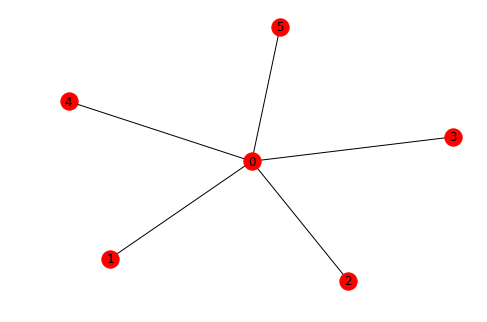

In [276]:
# A simple system's adjacency matrix
n = 5

def simple_graph(n: int):    
    A = np.zeros((n,n))
    A[0,0:n] = 1
    A = A.astype(int)
    return(A)

A = simple_graph(n+1)

print(A)

G = nx.from_numpy_matrix(np.array(A)) 
nx.draw(G, with_labels=True)



In [277]:
# Tanks' information
n = 5 
tank_ids = list(range(n))
tank_max_loads = [100, 100., 200., 300., 400.]
tank_current_loads = [50, 60., 120., 150., 300.]
tank_consumption_rates = [2] * n


In [278]:
# Trucks' information
k = 2
truck_ids = list(range(k))
truck_max_loads = [20., 50.]
truck_current_loads = truck_max_loads.copy()
truck_current_positions = [n] * k
truck_fractions_deliverable = [1.] * k # we for now we only allow to deliver all the content of the truck


In [279]:
# System's information
graph = simple_graph(n+1)
tanks = [Tank( tank_id, current_load, max_load, consumption_rate ) 
         for  tank_id, current_load, max_load, consumption_rate in 
         zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates)]
trucks = [Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable ) 
         for  truck_id, current_load, max_load, current_position, load_fractions_deliverable in 
         zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
             truck_fractions_deliverable)]

toy_system = System(tanks, trucks, graph)


In [280]:
for i in range(n):
    print(tanks[i].id) 

#print(toy_system.truck_loads())
print(toy_system.tank_loads())
print(toy_system.truck_positions())

print(toy_system.state())

#POSITION 'n' is the position of the Charge location (node 0 in the plot) ???? clarify notation and code

0
1
2
3
4
[50, 60.0, 120.0, 150.0, 300.0]
[5, 5]
[[5, 5], [20.0, 50.0], [50, 60.0, 120.0, 150.0, 300.0]]


In [281]:
print(toy_system.graph)

[[1 1 1 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [282]:
[trucks[j].load for j in range(k)]

[20.0, 50.0]

In [283]:
k

2

In [284]:
truck_current_positions 

[5, 5]